In [54]:
import praw
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Reddit API
reddit = praw.Reddit(
    client_id="ZFjjUMyDzY4YLl6YQM3aog",
    client_secret="sH-5g2ePUBefs6TcA8QLmtycI0RRaA",
    user_agent="python:myapp:v1.0",
)


In [55]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Step 2: Collect the Latest Indian Topics with at Least 200 Comments
def get_topics_with_min_comments(query, num_topics=5, min_comments=200):
    subreddit = reddit.subreddit('all').search(query, limit=None)
    topics = []
    for submission in subreddit:
        if submission.num_comments >= min_comments:
            topics.append({
                'title': submission.title,
                'url': submission.url,
                'id': submission.id,
                'created_utc': submission.created_utc,
                'num_comments': submission.num_comments,
                'score': submission.score
            })
        if len(topics) >= num_topics:
            break
    return topics

# Step 3: Collect Up to 200 Comments from Each Topic
def get_comments_from_topic(topic_id, limit=200):
    submission = reddit.submission(id=topic_id)
    submission.comments.replace_more(limit=0)  # Skip "load more comments" sections
    comments = []
    for comment in submission.comments.list()[:limit]:
        comments.append({
            'topic_id': topic_id,
            'comment_id': comment.id,
            'comment_body': comment.body,
            'comment_score': comment.score
        })
    return comments

# Step 4: Analyze Sentiment for Each Comment
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

# Step 5: Save Data to CSV
def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Main Execution
query = "india job"
min_comments = 200
num_topics = 5

topics = get_topics_with_min_comments(query, num_topics=num_topics, min_comments=min_comments)

all_comments = []
for topic in topics:
    comments = get_comments_from_topic(topic['id'], limit=min_comments)
    for comment in comments:
        comment['sentiment'] = analyze_sentiment(comment['comment_body'])
        comment['topic_title'] = topic['title']
    all_comments.extend(comments)

# Save the comments and their sentiment scores to a CSV file
save_to_csv(all_comments, 'latest_indian_job_news_comments_raw.csv')

# Print a summary of the topics and number of comments retrieved
for topic in topics:
    print(f"Title: {topic['title']}")
    print(f"URL: {topic['url']}")
    print(f"Comments Retrieved: {min(topic['num_comments'], min_comments)}\n")


Data saved to latest_indian_news_comments_raw.csv
Title: Railing Collapses As 1,800 Aspirants Turn Up For 10 Jobs In Gujarat, India
URL: https://v.redd.it/l21n269raxbd1
Comments Retrieved: 200

Title: What will the job market be like in two years? Especially in India
URL: https://www.reddit.com/r/developersIndia/comments/1e28uxc/what_will_the_job_market_be_like_in_two_years/
Comments Retrieved: 200

Title: Apple supplier Foxconn rejects married women from India iPhone jobs
URL: https://www.reuters.com/investigates/special-report/foxconn-apple-india-women/
Comments Retrieved: 200

Title: Google lays off hundreds of core employees and moves jobs to India and Mexico
URL: https://www.reddit.com/r/cscareerquestions/comments/1ci8s6g/google_lays_off_hundreds_of_core_employees_and/
Comments Retrieved: 200

Title: This is why jobs are outsourced to India
URL: https://i.redd.it/suwsghnng6431.jpg
Comments Retrieved: 200



In [56]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure required NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Step 1: Text Preprocessing Function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and numbers
    text = re.sub(r'\d+','', text)
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Step 2: Load the Raw Data from CSV
df = pd.read_csv('latest_indian_job_news_comments_raw.csv')

# Step 3: Apply Text Preprocessing to Each Comment
df['processed_comment'] = df['comment_body'].apply(preprocess_text)

# Step 4: Save the Processed Data to a New CSV File
df.to_csv('latest_indian_job_news_comments_processed.csv', index=False)
print("Processed data saved to 'latest_indian_job_news_comments_processed.csv'")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processed data saved to 'latest_indian_news_comments_processed.csv'


In [57]:
import pandas as pd

# Load the raw and preprocessed data from CSV files
raw_df = pd.read_csv('latest_indian_job_news_comments_raw.csv')
processed_df = pd.read_csv('latest_indian_job_news_comments_processed.csv')

# Merge the raw and preprocessed data on the comment_id
comparison_df = pd.merge(raw_df, processed_df[['comment_id', 'processed_comment']], on='comment_id', how='left')

# Check if there are any missing processed comments (which shouldn't normally happen)
missing_processed = comparison_df[comparison_df['processed_comment'].isnull()]
if not missing_processed.empty:
    print(f"Warning: There are {len(missing_processed)} comments missing from the preprocessed data.")

# Convert all entries to strings to avoid errors
comparison_df['comment_body'] = comparison_df['comment_body'].astype(str)
comparison_df['processed_comment'] = comparison_df['processed_comment'].astype(str)

# Save the comparison to a new CSV file
comparison_df.to_csv('comment_comparison.csv', index=False)

# Display a sample of the comparison
print(comparison_df[['comment_id', 'comment_body', 'processed_comment']].head(10))

# Optional: Print basic statistics or summaries
def get_word_count(series):
    return series.apply(lambda x: len(x.split()))

print("\nBasic Statistics:")
print("Raw Comments:")
print(get_word_count(comparison_df['comment_body']).describe())
print("\nProcessed Comments:")
print(get_word_count(comparison_df['processed_comment']).describe())


  comment_id                                       comment_body   
0    lcpqzyq           11 jobs now, someone to fix the railing.  \
1    lcpsvod  The 10 most intelligent guys left when they sa...   
2    lcpxrti                             more dystopian really.   
3    lcphbv7         Do they not have online applications? WTF.   
4    lcpy0s9                             This looks sustainable   
5    lcpzzi1       POV: the state of the tech industry in 2024.   
6    lcq579e  If India and China both had a billion fewer pe...   
7    lcqpx74  Apparently the unemployment rate is 9.2% ... t...   
8    lcpvdxo  Indians have a crazy sense of space. Fully loa...   
9    lcpy2m5                   If LinkedIn was an actual place!   

                                   processed_comment  
0                           jobs someone fix railing  
1                   intelligent guys left saw others  
2                                   dystopian really  
3                            online applic

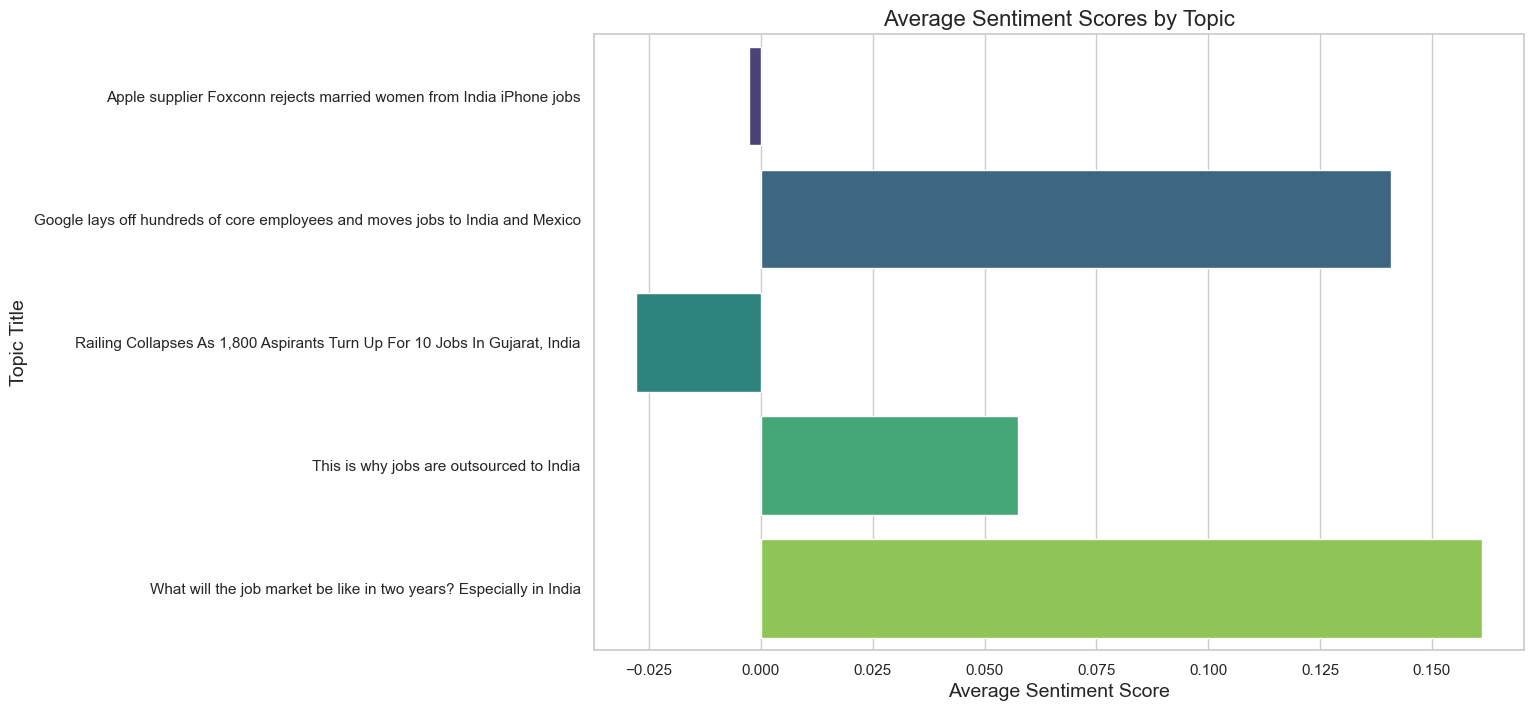

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
df = pd.read_csv('latest_indian_job_news_comments_processed.csv')

# Group by topic and calculate average sentiment score
sentiment_by_topic = df.groupby('topic_title')['sentiment'].mean().reset_index()

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot for sentiment by topic
plt.figure(figsize=(12, 8))
sns.barplot(x='sentiment', y='topic_title', data=sentiment_by_topic, palette='viridis')

# Add titles and labels
plt.title('Average Sentiment Scores by Topic', fontsize=16)
plt.xlabel('Average Sentiment Score', fontsize=14)
plt.ylabel('Topic Title', fontsize=14)

# Show the plot
plt.show()


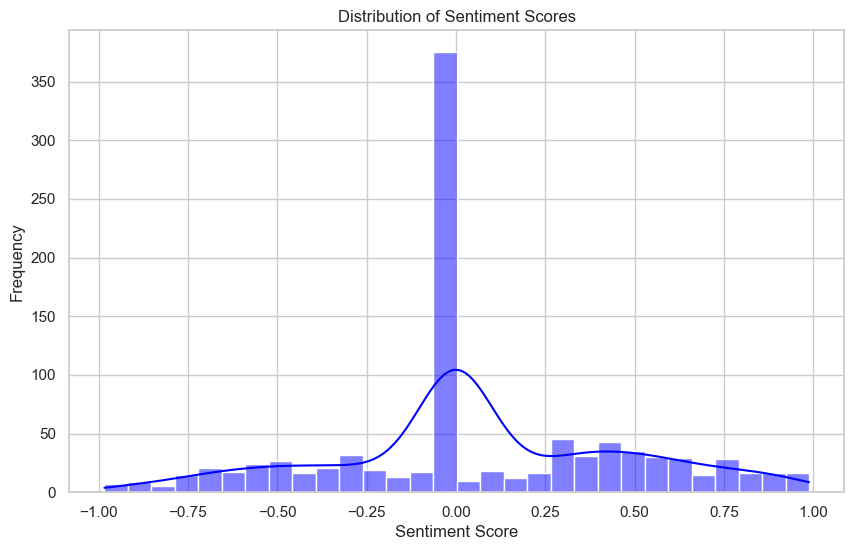

In [59]:
# Plot sentiment score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


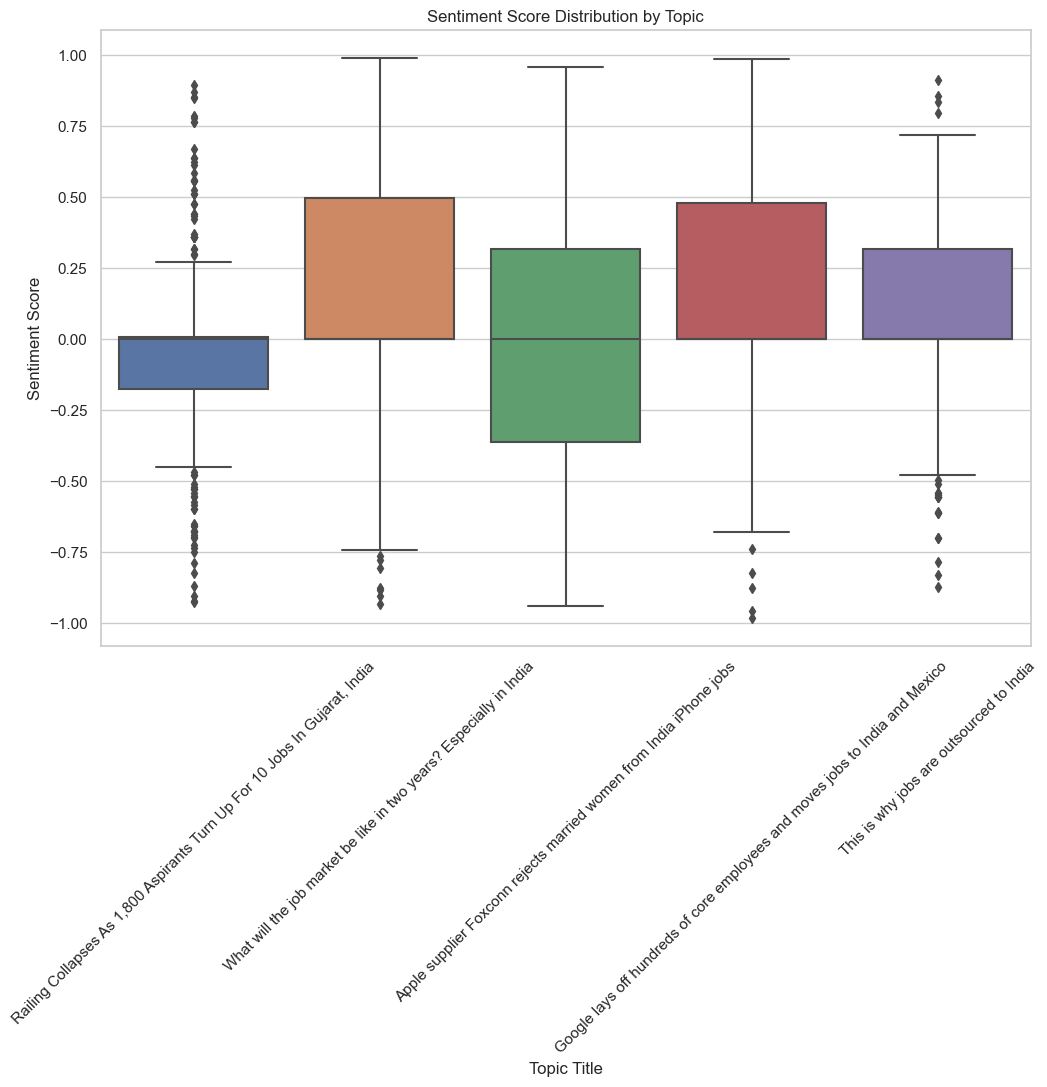

In [60]:
# Box plot for sentiment by topic
plt.figure(figsize=(12, 8))
sns.boxplot(x='topic_title', y='sentiment', data=df)
plt.title('Sentiment Score Distribution by Topic')
plt.xlabel('Topic Title')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


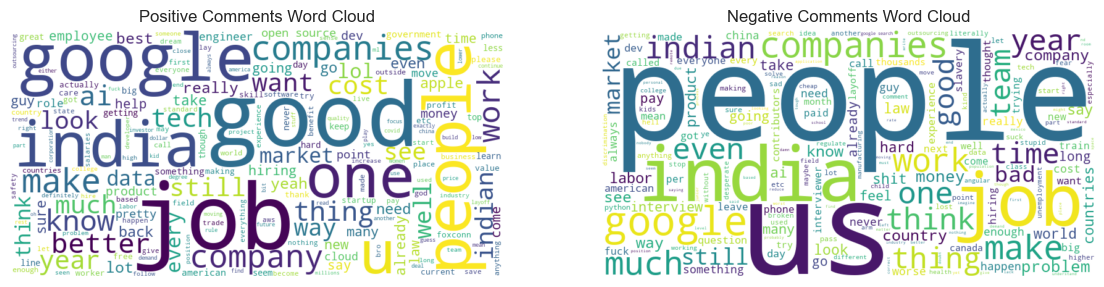

In [61]:
from wordcloud import WordCloud

# Filter positive and negative comments
positive_comments = df[df['sentiment'] > 0.1]['processed_comment'].str.cat(sep=' ')
negative_comments = df[df['sentiment'] < -0.1]['processed_comment'].str.cat(sep=' ')

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_comments)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_comments)

# Plot word clouds
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title('Positive Comments Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title('Negative Comments Word Cloud')
plt.axis('off')

plt.show()


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load and preprocess data
df = pd.read_csv('latest_indian_job_news_comments_processed.csv')
df = df.dropna(subset=['processed_comment'])
X = df['processed_comment']
y = df['sentiment'] > 0.1  # Example binary classification based on sentiment

# Vectorize text data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Neural Network (Simple Example)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences)

X_train_seq, X_test_seq, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

nn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=X_padded.shape[1]),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train_seq, y_train, epochs=5, batch_size=32, validation_split=0.1)
nn_predictions = (nn_model.predict(X_test_seq) > 0.5).astype("int32")


Epoch 1/5


c:\Users\vishn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step - accuracy: 0.6398 - loss: 0.6463 - val_accuracy: 0.6923 - val_loss: 0.6030
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.7899 - loss: 0.5910 - val_accuracy: 0.6923 - val_loss: 0.5861
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.8586 - loss: 0.4942 - val_accuracy: 0.7308 - val_loss: 0.5650
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.8974 - loss: 0.3090 - val_accuracy: 0.7564 - val_loss: 0.5373
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 373ms/step - accuracy: 0.9684 - loss: 0.1359 - val_accuracy: 0.7436 - val_loss: 0.6890
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


In [63]:
def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    roc_auc = roc_auc_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    
    return accuracy, precision, recall, f1, roc_auc, conf_matrix

# Logistic Regression Evaluation
lr_metrics = evaluate_model(lr_predictions, y_test)

# SVM Evaluation
svm_metrics = evaluate_model(svm_predictions, y_test)

# Random Forest Evaluation
rf_metrics = evaluate_model(rf_predictions, y_test)

# Gradient Boosting Evaluation
gb_metrics = evaluate_model(gb_predictions, y_test)

# Neural Network Evaluation
nn_metrics = evaluate_model(nn_predictions, y_test)

# Print the metrics for comparison
print("Logistic Regression Metrics:", lr_metrics)
print("SVM Metrics:", svm_metrics)
print("Random Forest Metrics:", rf_metrics)
print("Gradient Boosting Metrics:", gb_metrics)
print("Neural Network Metrics:", nn_metrics)


Logistic Regression Metrics: (0.711340206185567, 0.8666666666666667, 0.19402985074626866, 0.3170731707317073, 0.5891409096251028, array([[125,   2],
       [ 54,  13]], dtype=int64))
SVM Metrics: (0.7010309278350515, 0.9090909090909091, 0.14925373134328357, 0.2564102564102564, 0.570689857797626, array([[126,   1],
       [ 57,  10]], dtype=int64))
Random Forest Metrics: (0.7680412371134021, 0.8928571428571429, 0.373134328358209, 0.5263157894736842, 0.6747561405570572, array([[124,   3],
       [ 42,  25]], dtype=int64))
Gradient Boosting Metrics: (0.7628865979381443, 0.7837837837837838, 0.43283582089552236, 0.5576923076923077, 0.6849218474556352, array([[119,   8],
       [ 38,  29]], dtype=int64))
Neural Network Metrics: (0.7525773195876289, 0.6338028169014085, 0.6716417910447762, 0.6521739130434783, 0.7334586907979785, array([[101,  26],
       [ 22,  45]], dtype=int64))


In [64]:
import matplotlib.pyplot as plt

# Extract metrics for plotting
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'Neural Network']
accuracies = [lr_metrics[0], svm_metrics[0], rf_metrics[0], gb_metrics[0], nn_metrics[0]]
precisions = [lr_metrics[1], svm_metrics[1], rf_metrics[1], gb_metrics[1], nn_metrics[1]]
recalls = [lr_metrics[2], svm_metrics[2], rf_metrics[2], gb_metrics[2], nn_metrics[2]]
f1_scores = [lr_metrics[3], svm_metrics[3], rf_metrics[3], gb_metrics[3], nn_metrics[3]]
roc_aucs = [lr_metrics[4], svm_metrics[4], rf_metrics[4], gb_metrics[4], nn_metrics[4]]

# Plot metrics
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.bar(models, precisions, color='lightgreen')
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.bar(models, recalls, color='lightcoral')
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.bar(models, f1_scores, color='lightyellow')
plt.title('F1 Score')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(predictions, y_test):
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')
    roc_auc = roc_auc_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    
    return accuracy, precision, recall, f1, roc_auc, conf_matrix

# Evaluate models
lr_metrics = evaluate_model(lr_predictions, y_test)
svm_metrics = evaluate_model(svm_predictions, y_test)
rf_metrics = evaluate_model(rf_predictions, y_test)
gb_metrics = evaluate_model(gb_predictions, y_test)
nn_predictions = nn_predictions.flatten()
nn_metrics = evaluate_model(nn_predictions, y_test)


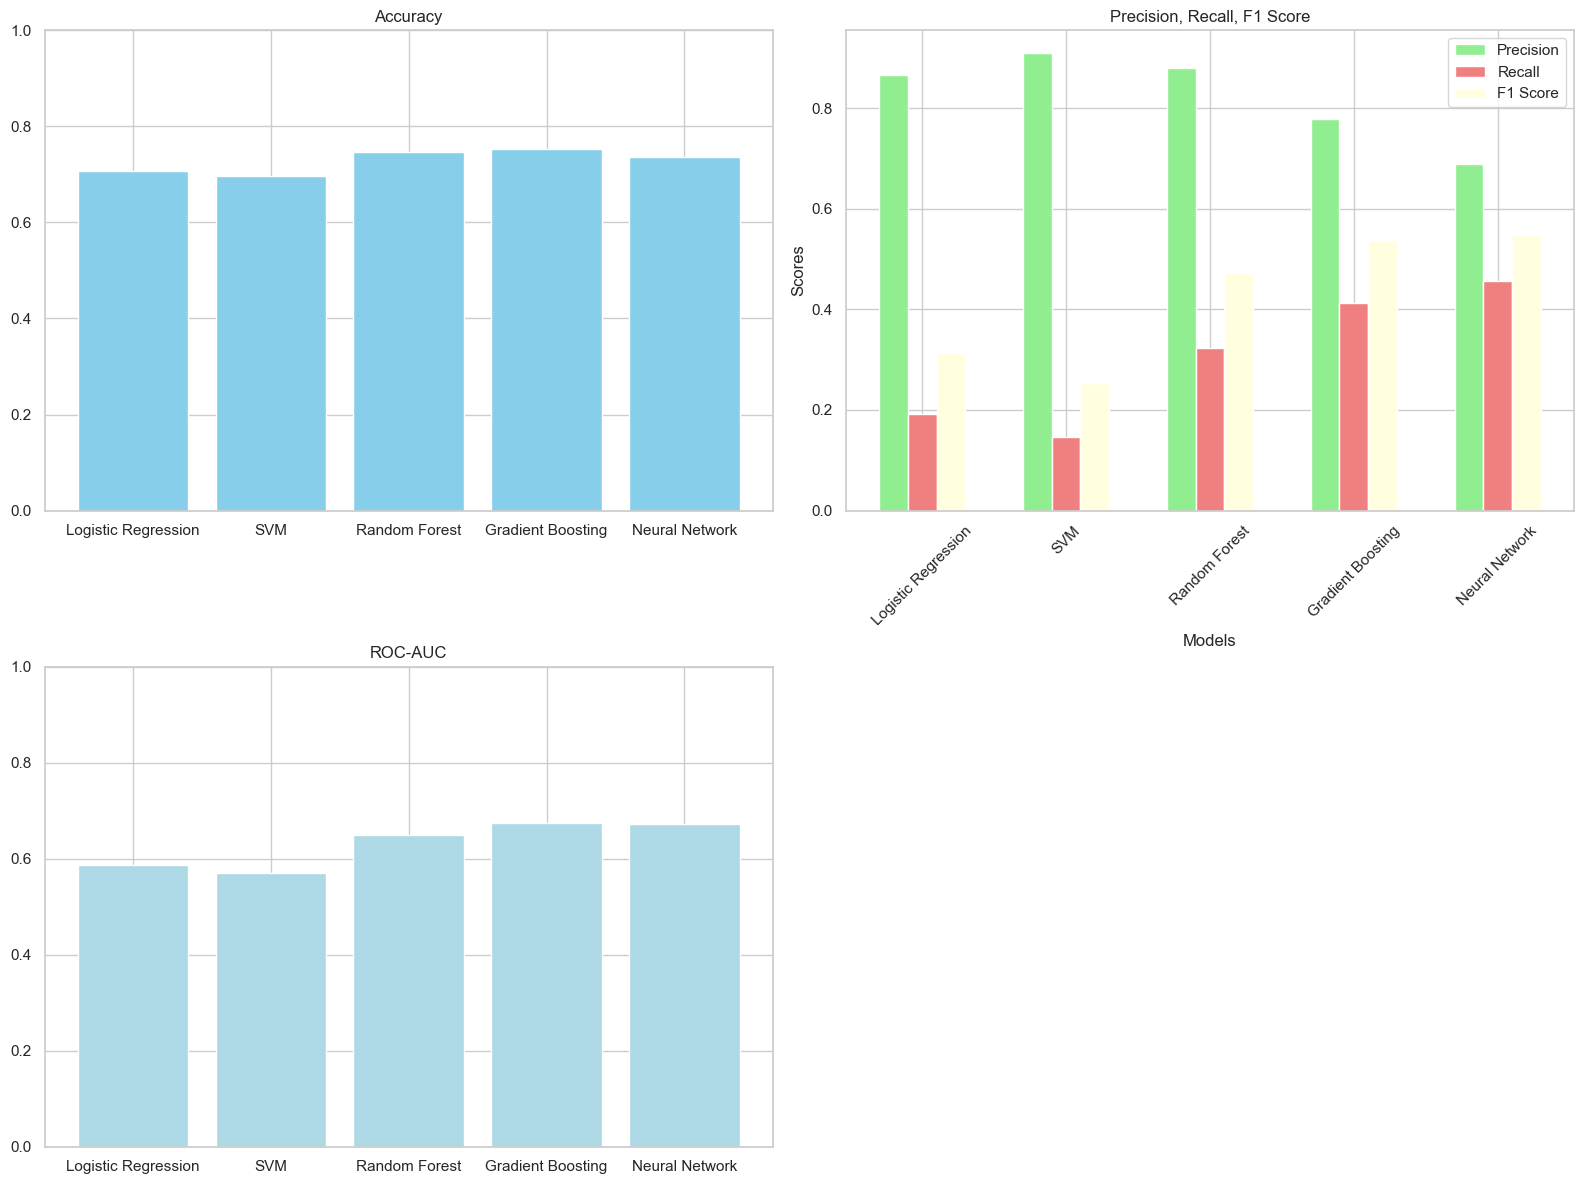

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract metrics for plotting
models = ['Logistic Regression', 'SVM', 'Random Forest', 'Gradient Boosting', 'Neural Network']
accuracies = [lr_metrics[0], svm_metrics[0], rf_metrics[0], gb_metrics[0], nn_metrics[0]]
precisions = [lr_metrics[1], svm_metrics[1], rf_metrics[1], gb_metrics[1], nn_metrics[1]]
recalls = [lr_metrics[2], svm_metrics[2], rf_metrics[2], gb_metrics[2], nn_metrics[2]]
f1_scores = [lr_metrics[3], svm_metrics[3], rf_metrics[3], gb_metrics[3], nn_metrics[3]]
roc_aucs = [lr_metrics[4], svm_metrics[4], rf_metrics[4], gb_metrics[4], nn_metrics[4]]

# Plot metrics
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
plt.bar(models, accuracies, color='skyblue')
plt.title('Accuracy')
plt.ylim([0, 1])

plt.subplot(2, 2, 2)
bar_width = 0.2
index = np.arange(len(models))
plt.bar(index, precisions, bar_width, label='Precision', color='lightgreen')
plt.bar(index + bar_width, recalls, bar_width, label='Recall', color='lightcoral')
plt.bar(index + 2*bar_width, f1_scores, bar_width, label='F1 Score', color='lightyellow')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Precision, Recall, F1 Score')
plt.xticks(index + bar_width, models, rotation=45)
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(models, roc_aucs, color='lightblue')
plt.title('ROC-AUC')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


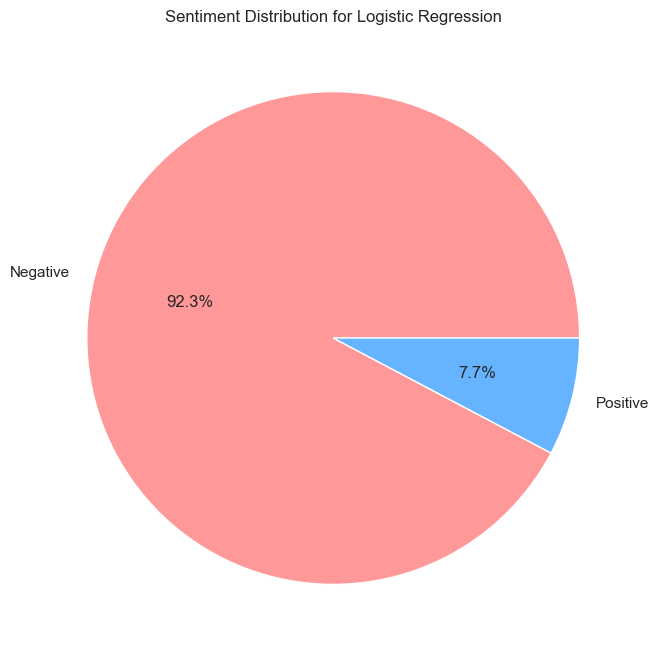

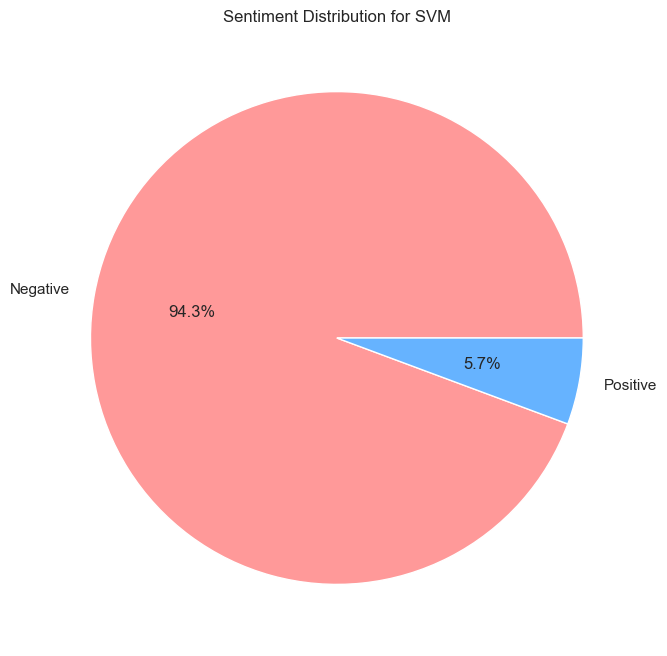

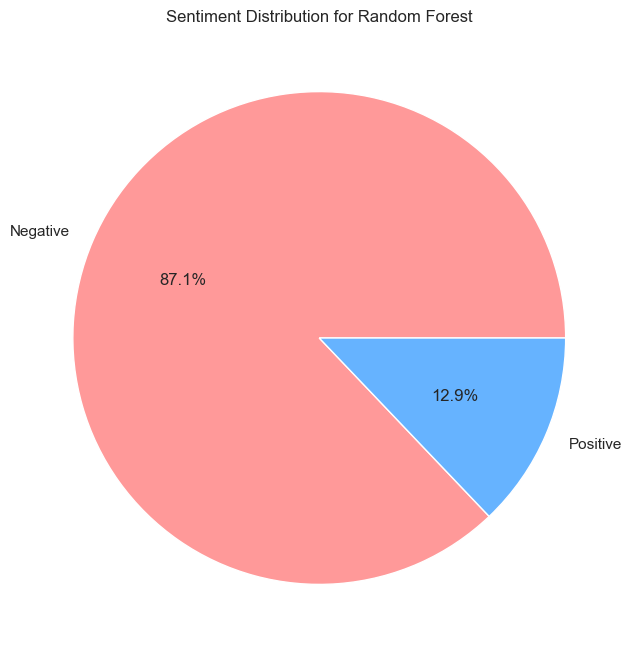

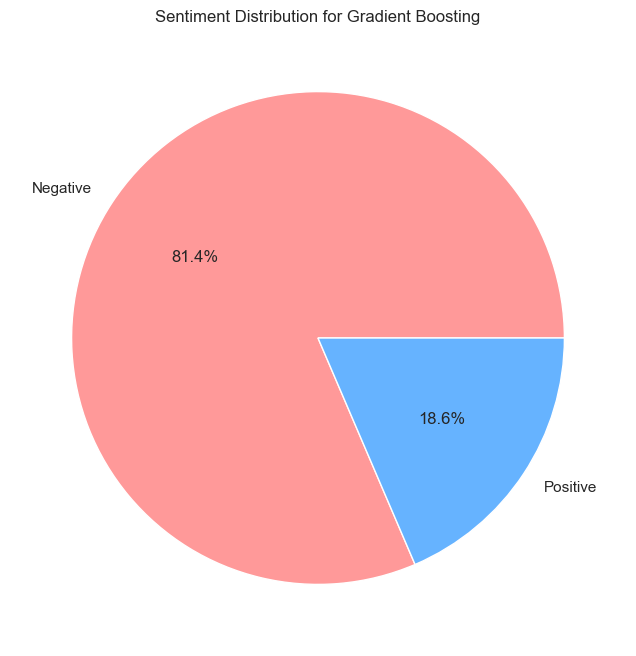

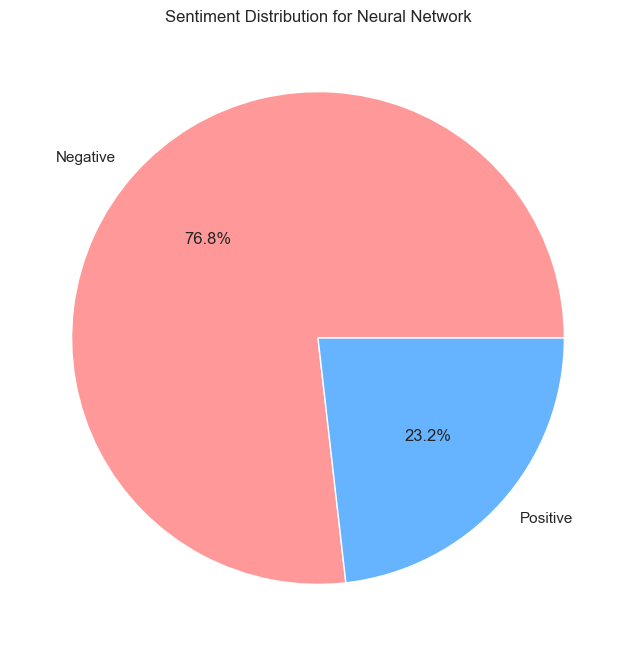

In [ ]:
# Define a function to create a pie chart for sentiment distribution
def plot_sentiment_pie_chart(predictions, model_name):
    # Aggregate sentiment predictions
    sentiment_counts = np.bincount(predictions)
    labels = ['Negative', 'Positive']
    
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    plt.title(f'Sentiment Distribution for {model_name}')
    plt.show()

# Plot sentiment distribution for each model
plot_sentiment_pie_chart(lr_predictions, 'Logistic Regression')
plot_sentiment_pie_chart(svm_predictions, 'SVM')
plot_sentiment_pie_chart(rf_predictions, 'Random Forest')
plot_sentiment_pie_chart(gb_predictions, 'Gradient Boosting')
plot_sentiment_pie_chart(nn_predictions, 'Neural Network')
